# Testing single-particle wave functions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ November 17, 2022

This notebook serves as a testbed for single-particle wave functions from a Wood-Saxon potential, and the SLy4 Skyrme functional using the `HFBRAD` code. The single-particle wave functions are inputs to the spectroscopic overlap $\langle \Psi_\alpha^{A-1} \lvert a_{\mathbf{q}} \rvert \Psi_0^A \rangle$.

_Last update:_ June 1, 2023

### Run `f2py` on the Wood-Saxon subroutine

In [1]:
# %%bash
# cd scripts
# python -m numpy.f2py -c woodsaxon.f90 -m woodsaxon
# cd ../

In [2]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

In [3]:
# Imports from scripts
from scripts.figures import (
    set_rc_parameters, label_nlj_state, label_nucleus, tab10_colors
)
from single_particle_states import SingleParticleState, WoodsSaxon

### Set-up

In [4]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [5]:
# Save figures in the following directory
figures_directory = '../figures/momentum_distributions/'

## Single-particle wave functions in coordinate space

In [6]:
def plot_sp_wfs_rspace(
        nucleus_name, Z, N, run_woodsaxon=False, n_max=None, l_max=None,
        x_limits=(0.0,10.0), y_limits=(0.0,0.8), save=False
):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""
    
    woods_saxon = WoodsSaxon(nucleus_name, Z, N, run_woodsaxon, n_max, l_max)

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Loop over s.p. states (keys in dictionary) and add s.p. wave function
    # to the figure (proton only)
    for sp_state in woods_saxon.sp_states:
        if sp_state.m_t == 1/2 and sp_state.m_j == sp_state.j:
            r_array, u_array = woods_saxon.get_wf_rspace(sp_state)
            ax.plot(r_array, u_array, linewidth=2.0,
                    label=label_nlj_state(sp_state.n, sp_state.l, sp_state.j))

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"proton $u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_rspace.png'
        f.savefig(figures_directory + file_name)

Coordinate space normalization = 1.0000000000359839.
Coordinate space normalization = 0.9999999998500226.


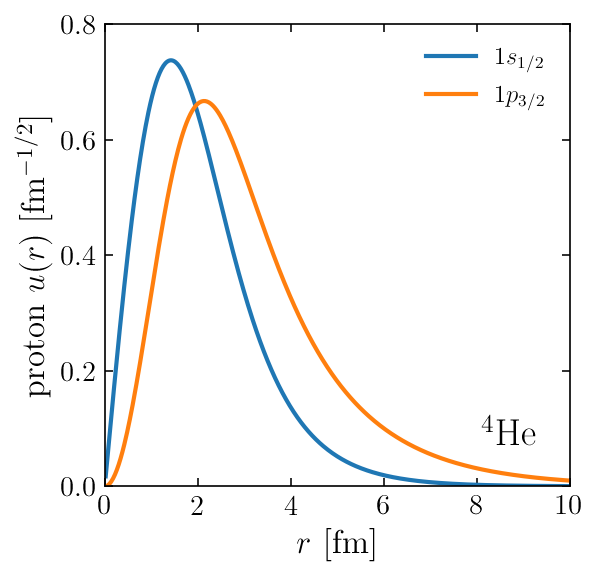

In [7]:
# Testing He4
nucleus_name, Z, N = 'He4', 2, 2
woods_saxon = WoodsSaxon(nucleus_name, Z, N, run_woodsaxon=False)

# Check normalization for 1s_{1/2}
r_array, u_array = woods_saxon.get_wf_rspace(
    SingleParticleState(1, 0, 1/2, 1/2, 1/2), print_normalization=True)

# Check normalization for 1p_{3/2}
r_array, u_array = woods_saxon.get_wf_rspace(SingleParticleState(1, 1, 3/2, 3/2, 1/2),
                                     print_normalization=True)

plot_sp_wfs_rspace(nucleus_name, Z, N, save=True)

The Wood-Saxon code gives two states that are bound ($E<0$). The other states say $E=0$ in the file `ws_log`.

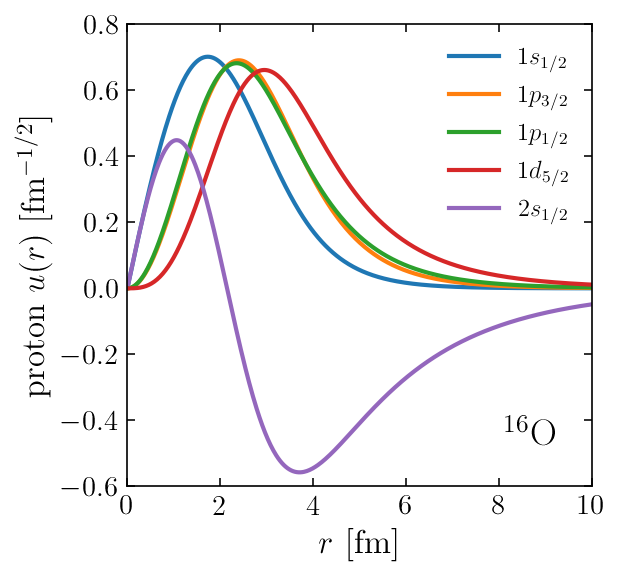

In [8]:
# Testing O16
plot_sp_wfs_rspace('O16', 8, 8, y_limits=(-0.6,0.8), save=True)

## Single-particle wave functions in momentum space

In [9]:
def plot_sp_wfs_kspace(
        nucleus_name, Z, N, run_woodsaxon=False, n_max=None, l_max=None,
        x_limits=(0.0,5.0), y_limits=(-0.1,4.0), save=False
):
    """Plot the s.p. wave functions of a nucleus in momentum space."""
    
    woods_saxon = WoodsSaxon(nucleus_name, Z, N, run_woodsaxon, n_max, l_max)

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Loop over s.p. states (keys in dictionary) and add s.p. wave function
    # to the figure (proton only)
    for sp_state in woods_saxon.sp_states:
        
        if sp_state.m_t == 1/2 and sp_state.m_j == sp_state.j:
            
            k_array, _, phi_array = woods_saxon.get_wf_kspace(
                sp_state, 10.0, 2.0, 120)
            
            nlj_label = label_nlj_state(sp_state.n, sp_state.l, sp_state.j)
            
            ax.plot(k_array, np.abs(phi_array), label=nlj_label, linewidth=2.0)
            
            phi_func = woods_saxon.get_wf_kspace(
                sp_state, 10.0, 2.0, 120, interpolate=True)

            k_fine_array = np.linspace(k_array[0], k_array[-1], 1000)
            phi_fine_array = phi_func(k_fine_array)
            ax.plot(k_fine_array, np.abs(phi_fine_array), label=nlj_label + ' interpolated', linewidth=2.0)

    # Add horizontal line at y=0
    ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"proton $|\phi(k)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_kspace.png'
        f.savefig(figures_directory + file_name)

Momentum space normalization = 1.0000000000276594.
Momentum space normalization = 0.9999999997957603.


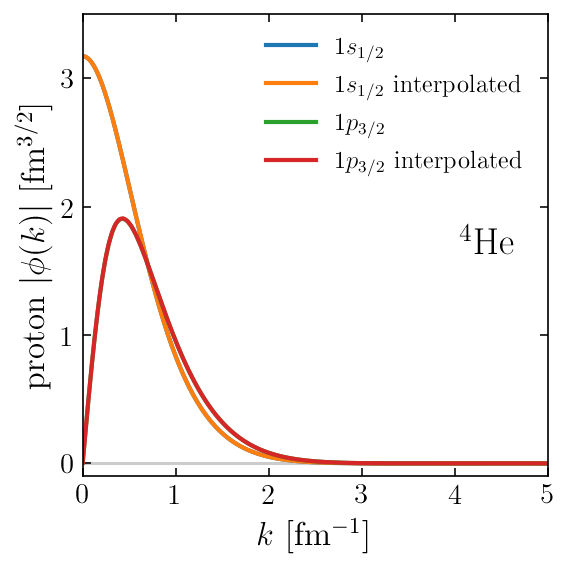

In [10]:
# Testing He4

kmax, kmid, ntot = 10.0, 2.0, 120

# Check normalization for 1s_{1/2}
k_array, k_weights, phi_array = woods_saxon.get_wf_kspace(
    SingleParticleState(1, 0, 1/2, 1/2, 1/2), kmax, kmid, ntot,
    print_normalization=True
)

# Check normalization for 1p_{3/2}
k_array, k_weights, phi_array = woods_saxon.get_wf_kspace(
    SingleParticleState(1, 1, 3/2, 3/2, 1/2), kmax, kmid, ntot,
    print_normalization=True
)

plot_sp_wfs_kspace(nucleus_name, Z, N, y_limits=(-0.1,3.5), save=True)